# Looping through and fitting multiple impedance data sets

In [1]:
import os
import sys
sys.path.append('../../../')

import glob
import numpy as np

## 1. Find all files that match a specified pattern

#### Using a search string to find .z files that contain "Circuit" at the beginning and EIS towards the end

In [2]:
directory = r'../../../data/'
all_files = glob.glob(os.path.join(directory, 'Circuit*EIS*.z'))
all_files

['../../../data\\Circuit1_EIS_1.z',
 '../../../data\\Circuit1_EIS_2.z',
 '../../../data\\Circuit2_EIS_1.z',
 '../../../data\\Circuit2_EIS_2.z',
 '../../../data\\Circuit3_EIS_1.z',
 '../../../data\\Circuit3_EIS_2.z']

### 2. Use preprocessing module to read in ZPlot data

In [3]:
from impedance import preprocessing
# Initialize some empty lists for the frequencies and Z data
freqs = []
Zs = []

# Now loop through file names in our list and extract data one by one
for filename in all_files:
    f, Z = preprocessing.readZPlot(filename)
    freqs.append(f)
    Zs.append(Z)

# Check to see if we extracted data for all the files
print(np.shape(Zs), np.shape(all_files))

(6,) (6,)


## 3. Create a list of circuit models

In [4]:
from impedance.models.circuits import CustomCircuit
# This data comes from dummy circuits I made to check measurement bias in
# our potentiostat, so I know a priori its an R-RC circuit

circuits = []

circ_string = 'R0-p(R1,C1)'
initial_guess = [100, 400, 1e-5]

# Now loop through data list to create circuits and fit them
for f, Z, filename in zip(freqs, Zs, all_files):
    name = filename.split('/')[-1]
    circuit = CustomCircuit(circ_string, initial_guess=initial_guess, name=name)
    circuit.fit(f, Z)
    circuits.append(circuit)

We now have a list of our circuit class objects, all fit to different sets of
data. As you may notice from the file names, there are three unique circuits
each with a replicate set of data. We expect each of the replicates to fit
similarly.

In [5]:
for circuit in circuits:
    print(circuit)


Name: data\Circuit1_EIS_1.z
Circuit string: R0-p(R1,C1)
Fit: True

Initial guesses:
     R0 = 1.00e+02 [Ohm]
     R1 = 4.00e+02 [Ohm]
     C1 = 1.00e-05 [F]

Fit parameters:
     R0 = 2.91e+01  (+/- 3.63e-02) [Ohm]
     R1 = 4.67e+01  (+/- 4.69e-02) [Ohm]
     C1 = 1.04e-05  (+/- 2.95e-08) [F]


Name: data\Circuit1_EIS_2.z
Circuit string: R0-p(R1,C1)
Fit: True

Initial guesses:
     R0 = 1.00e+02 [Ohm]
     R1 = 4.00e+02 [Ohm]
     C1 = 1.00e-05 [F]

Fit parameters:
     R0 = 2.91e+01  (+/- 3.58e-02) [Ohm]
     R1 = 4.67e+01  (+/- 4.64e-02) [Ohm]
     C1 = 1.04e-05  (+/- 2.91e-08) [F]


Name: data\Circuit2_EIS_1.z
Circuit string: R0-p(R1,C1)
Fit: True

Initial guesses:
     R0 = 1.00e+02 [Ohm]
     R1 = 4.00e+02 [Ohm]
     C1 = 1.00e-05 [F]

Fit parameters:
     R0 = 1.50e+02  (+/- 3.23e-01) [Ohm]
     R1 = 5.02e+02  (+/- 3.57e-01) [Ohm]
     C1 = 3.12e-08  (+/- 7.79e-11) [F]


Name: data\Circuit2_EIS_2.z
Circuit string: R0-p(R1,C1)
Fit: True

Initial guesses:
     R0 = 1.00e+02 [Ohm]

Now we'll get the impedance predicted by the fit parameters

In [6]:
fits = []
for f, circuit in zip(freqs, circuits):
    fits.append(circuit.predict(f))

## 4. Plot the data and fits 
Now we can visualize the data and fits. For now we'll place them all on the same axis

In [7]:
import matplotlib.pyplot as plt
from impedance.visualization import plot_nyquist, plot_bode

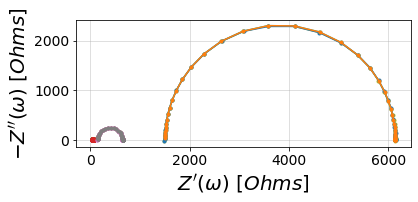

In [8]:
fig, ax = plt.subplots()

for fit, Z in zip(fits, Zs):  
    # Plotting data
    plot_nyquist(ax, Z)

    # Plotting fit
    plot_nyquist(ax, fit)

plt.show()

Since the circuits have different orders of magnitude impedance, this looks bad
so let's put each pair of data on separate axes. 

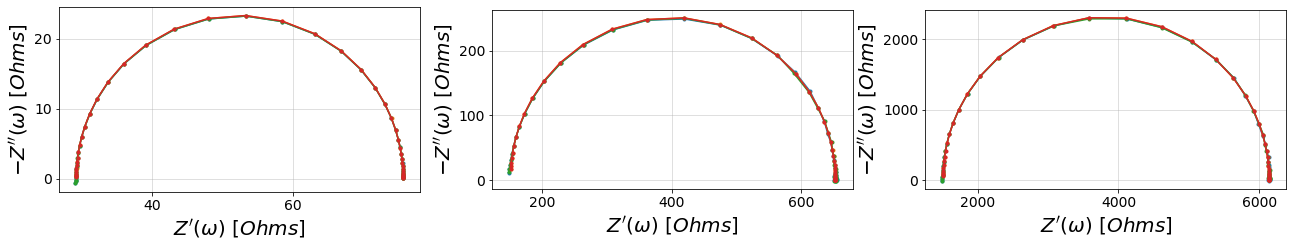

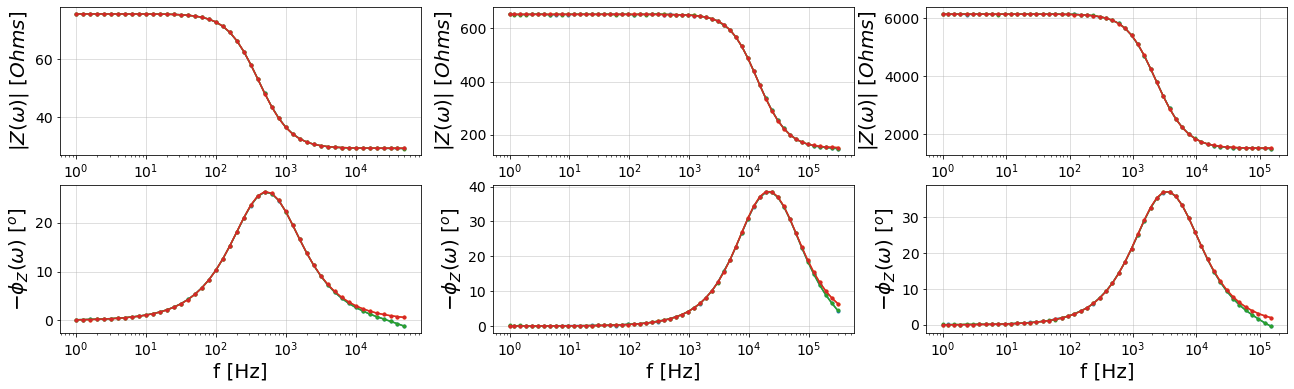

In [9]:
# Nyquist plots
fig, axes = plt.subplots(ncols=3, figsize=(22,6))
for circuit, Z, fit in zip(circuits, Zs, fits):
    n = int(circuit.name.split('Circuit')[-1].split('_')[0])
    plot_nyquist(axes[n - 1], Z)
    plot_nyquist(axes[n - 1], fit)
    
# Bode plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22,6))
for circuit, f, Z, fit in zip(circuits, freqs, Zs, fits):
    n = int(circuit.name.split('Circuit')[-1].split('_')[0])
    plot_bode([axes[0][n - 1], axes[1][n - 1]], f, Z)
    plot_bode([axes[0][n - 1], axes[1][n - 1]], f, fit)

plt.show()